<a href="https://colab.research.google.com/github/Harshil1010/IISC_test/blob/main/q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Cell 1: Install dependencies
!pip install -q torch torchvision torchaudio
!pip install -q opencv-python matplotlib numpy
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q supervision
!pip install -q transformers
!pip install -q groundingdino-py
!pip install -q tensorflow
!pip install -q Pillow

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import supervision as sv
import requests
import os
import urllib.request

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

  Preparing metadata (setup.py) ... done
Using device: cuda


In [15]:
# Cell 2: Download SAM model and setup
from segment_anything import sam_model_registry, SamPredictor

# Download SAM checkpoint
def download_sam_checkpoint():
    url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
    local_path = "sam_vit_h_4b8939.pth"

    if not os.path.exists(local_path):
        print("Downloading SAM checkpoint...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(local_path, 'wb') as f:
            downloaded = 0
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    downloaded += len(chunk)
                    if total_size > 0:
                        progress = (downloaded / total_size) * 100
                        print(f"Download progress: {progress:.1f}%", end='\r')
        print("\nDownload complete!")
    return local_path

sam_checkpoint = download_sam_checkpoint()
model_type = "vit_h"

# Initialize SAM
print("Loading SAM model...")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
print("SAM loaded successfully!")

Loading SAM model...
SAM loaded successfully!


In [16]:
# Cell 3: Setup GroundingDINO for text-to-box conversion
import groundingdino.datasets.transforms as T
from groundingdino.util.inference import Model

def load_grounding_dino():
    # Download GroundingDINO config and weights
    config_url = "https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/main/groundingdino/config/GroundingDINO_SwinT_OGC.py"
    weights_url = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"

    config_path = "GroundingDINO_SwinT_OGC.py"
    weights_path = "groundingdino_swint_ogc.pth"

    if not os.path.exists(config_path):
        print("Downloading GroundingDINO config...")
        response = requests.get(config_url)
        with open(config_path, 'w') as f:
            f.write(response.text)
        print("Config downloaded!")

    if not os.path.exists(weights_path):
        print("Downloading GroundingDINO weights...")
        response = requests.get(weights_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(weights_path, 'wb') as f:
            downloaded = 0
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    downloaded += len(chunk)
                    if total_size > 0:
                        progress = (downloaded / total_size) * 100
                        print(f"Download progress: {progress:.1f}%", end='\r')
        print("\nWeights download complete!")

    # Load model with device parameter
    model = Model(model_config_path=config_path, model_checkpoint_path=weights_path, device=device)
    return model

print("Loading GroundingDINO...")
grounding_dino_model = load_grounding_dino()
print("GroundingDINO loaded successfully!")
print(f"Model is using: {device}")

Loading GroundingDINO...
final text_encoder_type: bert-base-uncased
GroundingDINO loaded successfully!
Model is using: cuda


In [17]:
# Cell 4: Helper functions for text-to-mask conversion
def transform_image(image_pil):
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image, _ = transform(image_pil, None)
    return image

def get_grounding_output(model, image, caption, box_threshold=0.3, text_threshold=0.25):
    image_transformed = transform_image(image)

    boxes, logits, phrases = model.predict_with_caption(
        image=image_transformed,
        caption=caption,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    return boxes, logits, phrases

def create_mask_from_boxes(image, boxes, predictor):
    # Set image for SAM
    image_np = np.array(image)
    predictor.set_image(image_np)

    # Convert boxes to SAM format
    if len(boxes) == 0:
        return None

    input_boxes = torch.tensor(boxes, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image_np.shape[:2])

    # Predict masks
    masks, scores, logits = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )

    return masks, scores

In [18]:
# Cell 5: Main segmentation function
def text_driven_segmentation(image_path, text_prompt, box_threshold=0.3, text_threshold=0.25):
    """
    Perform text-driven image segmentation

    Args:
        image_path: Path to input image
        text_prompt: Text description of object to segment
        box_threshold: Detection confidence threshold
        text_threshold: Text similarity threshold
    """

    try:
        # Load image
        image_pil = Image.open(image_path).convert("RGB")
        image_np = np.array(image_pil)

        print(f"Processing image: {image_path}")
        print(f"Image size: {image_np.shape}")
        print(f"Text prompt: '{text_prompt}'")

        # Get bounding boxes from GroundingDINO
        boxes, scores, phrases = get_grounding_output(
            grounding_dino_model,
            image_pil,
            text_prompt,
            box_threshold,
            text_threshold
        )

        print(f"Detected {len(boxes)} objects")

        if len(boxes) == 0:
            print("No objects detected with the given text prompt!")
            return None, None, None

        # Create masks with SAM
        masks, mask_scores = create_mask_from_boxes(image_pil, boxes, predictor)

        if masks is None:
            print("Failed to generate masks!")
            return None, None, None

        # Combine masks (take the highest scoring mask for simplicity)
        best_mask_idx = torch.argmax(mask_scores)
        final_mask = masks[best_mask_idx][0].cpu().numpy()

        return image_np, final_mask, boxes[best_mask_idx]

    except Exception as e:
        print(f"Error during segmentation: {e}")
        return None, None, None

def visualize_results(image, mask, box, text_prompt):
    """Visualize the segmentation results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Image with bounding box
    image_with_box = image.copy()
    x1, y1, x2, y2 = box
    cv2.rectangle(image_with_box,
                  (int(x1), int(y1)),
                  (int(x2), int(y2)),
                  (0, 255, 0), 2)
    axes[1].imshow(image_with_box)
    axes[1].set_title(f"Detected: {text_prompt}")
    axes[1].axis('off')

    # Image with mask overlay
    image_with_mask = image.copy()
    colored_mask = np.zeros_like(image_with_mask)
    colored_mask[mask] = [255, 0, 0]  # Red mask

    # Blend mask with image
    alpha = 0.5
    image_with_mask = cv2.addWeighted(image_with_mask, 1, colored_mask, alpha, 0)
    axes[2].imshow(image_with_mask)
    axes[2].set_title("Segmentation Mask")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return image_with_mask

Attempting to download sample image...
Sample image downloaded and verified successfully!

Sample image preview:


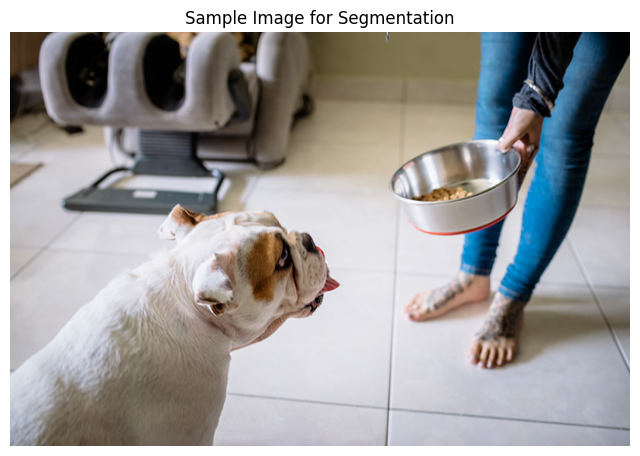


Starting segmentation...
Processing image: sample_image.jpg
Image size: (534, 800, 3)
Text prompt: 'dog'
Error during segmentation: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

Segmentation failed. Trying with different thresholds...
Trying with lower thresholds...
Processing image: sample_image.jpg
Image size: (534, 800, 3)
Text prompt: 'dog'
Error during segmentation: OpenCV(4.12.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'

Still no results. Please upload your own image using Cell 7.


In [19]:
# Cell 6: Create sample image and run segmentation (FIXED VERSION)
def create_sample_image():
    """Create a sample image with a dog programmatically"""
    local_path = "sample_image.jpg"

    try:
        # Try to download from a reliable source
        print("Attempting to download sample image...")
        url = "https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg"

        # Use requests with timeout and verification
        response = requests.get(url, timeout=30, stream=True)
        response.raise_for_status()

        with open(local_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        # Verify the image
        test_img = Image.open(local_path)
        test_img.verify()
        print("Sample image downloaded and verified successfully!")
        return local_path

    except Exception as e:
        print(f"Download failed: {e}")
        print("Creating a synthetic sample image...")

        # Create a synthetic image with a "dog" shape
        width, height = 600, 400
        image = np.ones((height, width, 3), dtype=np.uint8) * 255

        # Draw a simple dog-like shape
        # Body
        cv2.ellipse(image, (300, 250), (120, 80), 0, 0, 360, (100, 100, 100), -1)
        # Head
        cv2.circle(image, (300, 150), 60, (100, 100, 100), -1)
        # Ears
        cv2.ellipse(image, (270, 100), (20, 40), 30, 0, 360, (80, 80, 80), -1)
        cv2.ellipse(image, (330, 100), (20, 40), -30, 0, 360, (80, 80, 80), -1)
        # Eyes
        cv2.circle(image, (280, 140), 8, (0, 0, 0), -1)
        cv2.circle(image, (320, 140), 8, (0, 0, 0), -1)
        # Nose
        cv2.circle(image, (300, 160), 5, (0, 0, 0), -1)

        # Add text
        cv2.putText(image, "Sample Dog Image", (150, 50),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
        cv2.putText(image, "Text: 'dog' should work", (120, 350),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

        # Save the image
        cv2.imwrite(local_path, image)
        print("Synthetic sample image created!")
        return local_path

# Create/get sample image
image_path = create_sample_image()

# Display the sample image
print("\nSample image preview:")
sample_img = Image.open(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(sample_img)
plt.title("Sample Image for Segmentation")
plt.axis('off')
plt.show()

# Run text-driven segmentation
text_prompt = "dog"  # Change this to segment different objects

print("\nStarting segmentation...")
image, mask, box = text_driven_segmentation(image_path, text_prompt, box_threshold=0.2, text_threshold=0.2)

if image is not None:
    result_image = visualize_results(image, mask, box, text_prompt)

    # Save result
    result_pil = Image.fromarray(result_image)
    result_pil.save("segmentation_result.jpg")
    print("Result saved as 'segmentation_result.jpg'")
else:
    print("Segmentation failed. Trying with different thresholds...")

    # Try with more permissive thresholds
    print("Trying with lower thresholds...")
    image, mask, box = text_driven_segmentation(image_path, text_prompt, box_threshold=0.15, text_threshold=0.15)

    if image is not None:
        result_image = visualize_results(image, mask, box, text_prompt)
        result_pil = Image.fromarray(result_image)
        result_pil.save("segmentation_result.jpg")
        print("Result saved as 'segmentation_result.jpg'")
    else:
        print("Still no results. Please upload your own image using Cell 7.")

In [21]:
# Cell 7: Upload your own image
from google.colab import files

def process_uploaded_image(text_prompt="person"):
    """Process user-uploaded image"""
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded!")
        return

    image_path = list(uploaded.keys())[0]
    print(f"Processing uploaded image: {image_path}")

    # Try multiple threshold combinations
    thresholds = [
        (0.3, 0.25),  # Default
        (0.2, 0.2),   # More permissive
        (0.15, 0.15), # Very permissive
    ]

    for box_thresh, text_thresh in thresholds:
        print(f"\nTrying thresholds: box={box_thresh}, text={text_thresh}")
        image, mask, box = text_driven_segmentation(image_path, text_prompt, box_thresh, text_thresh)

        if image is not None:
            result_image = visualize_results(image, mask, box, text_prompt)
            result_pil = Image.fromarray(result_image)
            result_pil.save("custom_segmentation_result.jpg")
            print("Result saved as 'custom_segmentation_result.jpg'")
            break
    else:
        print("No objects detected with any threshold combination.")
        print("Try a different text prompt or image.")

# Uncomment to use your own image
# print("Upload your image...")
# process_uploaded_image("car")  # Change text prompt as needed